In [ ]:
from google.colab import files
files.upload()  # Pilih file kaggle.json yang sudah di-download


In [ ]:
# Membuat folder .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Menyalin file kaggle.json ke folder yang tepat
!cp kaggle.json ~/.kaggle/

# Mengatur izin agar file dapat dibaca dengan aman
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog


In [ ]:
!unzip cat-and-dog.zip -d /content/dataset


In [ ]:
!ls /content/dataset


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Transformasi gambar (ubah ukuran, normalisasi, dll.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Ukuran gambar
    transforms.ToTensor(),           # Mengubah gambar ke tensor
])

# Menyiapkan dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset', transform=transform)

# Membagi dataset menjadi training dan test set
train_size = int(0.8 * len(dataset))  # 80% untuk training
test_size = len(dataset) - train_size  # 20% untuk testing

train_set, test_set = random_split(dataset, [train_size, test_size])

# Membuat DataLoader untuk training dan testing
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



# Definisikan transformasi untuk input dan target
transform_input = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ubah gambar menjadi grayscale (RGB)
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform_target = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Tentukan direktori input dan target
input_dir = '/content/drive/MyDrive/dataset/training_set/training_set/cat'
target_dir = '/content/drive/MyDrive/dataset/training_set/training_set/dog'

# Buat dataset kustom
class CustomImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform_input=None, transform_target=None):
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir)])
        self.target_paths = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir)])
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_image = Image.open(self.input_paths[idx]).convert('RGB')
        target_image = Image.open(self.target_paths[idx]).convert('RGB')
        if self.transform_input:
            input_image = self.transform_input(input_image)
        if self.transform_target:
            target_image = self.transform_target(target_image)
        return input_image, target_image

# Apply Dataset
dataset = CustomImageDataset(input_dir=input_dir, target_dir=target_dir,
                              transform_input=transform_input, transform_target=transform_target)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definisikan model Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid untuk mengembalikan nilai antara 0-1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
# Inisialisasi model
model = Autoencoder()

# Tentukan fungsi loss dan optimizer
criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer Adam


In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset

# Definisikan dataset yang memfilter file non-gambar
class CustomImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform_input=None, transform_target=None):
        # Memfilter hanya file gambar (mengabaikan _DS_Store dan file non-gambar lainnya)
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.target_paths = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_image = Image.open(self.input_paths[idx]).convert('RGB')
        target_image = Image.open(self.target_paths[idx]).convert('RGB')
        if self.transform_input:
            input_image = self.transform_input(input_image)
        if self.transform_target:
            target_image = self.transform_target(target_image)
        return input_image, target_image

# Apply Dataset
dataset = CustomImageDataset(input_dir=input_dir, target_dir=target_dir,
                              transform_input=transform_input, transform_target=transform_target)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [11]:
model.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Menonaktifkan gradien untuk evaluasi
    test_loss = 0.0
    for i, (input_images, target_images) in enumerate(dataloader):
        input_images = input_images.cuda() if torch.cuda.is_available() else input_images
        target_images = target_images.cuda() if torch.cuda.is_available() else target_images
        outputs = model(input_images)
        loss = criterion(outputs, target_images)
        test_loss += loss.item()

    print(f"Test Loss: {test_loss / len(dataloader)}")


Test Loss: 0.06250168457627296


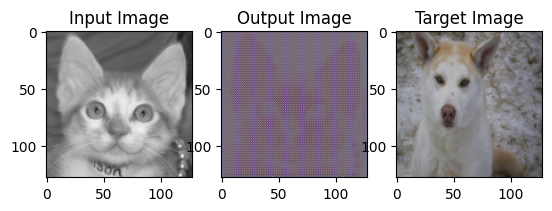

In [13]:
import matplotlib.pyplot as plt

# Ambil batch pertama dari dataloader untuk evaluasi
input_image, target_image = next(iter(dataloader))

# Pindahkan gambar ke device yang sesuai
input_image = input_image.cuda() if torch.cuda.is_available() else input_image
output_image = model(input_image)

# Menampilkan gambar
fig, axs = plt.subplots(1, 3)
axs[0].imshow(input_image[0].cpu().squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')

axs[1].imshow(output_image[0].detach().cpu().squeeze().permute(1, 2, 0), cmap='gray')
axs[1].set_title('Output Image')

axs[2].imshow(target_image[0].cpu().squeeze().permute(1, 2, 0), cmap='gray')
axs[2].set_title('Target Image')

plt.show()


In [14]:
torch.save(model.state_dict(), 'autoencoder_model.pth')


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os

project_dir = "/content/autoencoder.ipynb"
os.makedirs(project_dir, exist_ok=True)


In [26]:
from google.colab import drive
from google.colab import files

# Simpan notebook saat ini ke folder
!cp "/content/autoencoder.ipynb" "/content/autoencode/"


cp: -r not specified; omitting directory '/content/autoencoder.ipynb'
